In [1]:
import pandas as pd
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from mapclassify import Quantiles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import seaborn as sns
import random

In [2]:
data_path = df = "./harth"

In [3]:
all_files = glob.glob(data_path + "/*.csv")

# List to hold dataframes
dfs = []

# Loop through each file, read it into a DataFrame, and append to list
for filename in all_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716225 entries, 0 to 1716224
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  object 
 1   back_x     float64
 2   back_y     float64
 3   back_z     float64
 4   thigh_x    float64
 5   thigh_y    float64
 6   thigh_z    float64
 7   label      int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 104.8+ MB


In [6]:
#df = df.drop(columns=['Unnamed: 0'])
#df = df.drop(columns=['index'])

In [7]:
null_counts = df.isnull().sum()
print(null_counts)

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [8]:
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-1.455469,0.199820,-0.000919,-0.658926,-0.369698,0.982122,6
1,2019-01-12 00:00:00.020,-0.969411,-0.113875,0.068938,-0.765164,0.839769,-0.646512,6
2,2019-01-12 00:00:00.040,-0.728391,0.000811,0.341911,-0.579921,0.306608,-0.523581,6
3,2019-01-12 00:00:00.060,-0.859020,0.222991,0.012635,-0.127765,-0.779781,-0.148429,6
4,2019-01-12 00:00:00.080,-0.561594,0.189641,0.098114,-0.809730,-0.222737,-0.392332,6


In [9]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06
mean,-9.136983e-01,5.232557e-03,-1.490021e-01,-5.126834e-01,6.135588e-02,5.457297e-01,8.036718e+00
std,2.165355e-01,1.429115e-01,3.586170e-01,5.332363e-01,2.403650e-01,5.939551e-01,1.449372e+01
min,-5.238408e+00,-3.016498e+00,-1.353473e+00,-6.863094e+00,-5.757406e+00,-5.651375e+00,1.000000e+00
25%,-1.002036e+00,-4.289968e-02,-3.162953e-01,-9.743656e-01,-5.570871e-02,-1.153043e-02,6.000000e+00
50%,-9.833325e-01,2.237414e-02,-8.577258e-02,-3.685415e-01,5.961482e-02,9.013961e-01,7.000000e+00
75%,-8.589005e-01,7.544386e-02,6.995789e-02,-6.059147e-02,1.654058e-01,9.945638e-01,7.000000e+00
max,9.521087e-01,2.589111e+00,4.909483e+00,4.092486e+00,4.809320e+00,5.391660e+00,1.400000e+02


In [10]:
df.shape

(1716225, 8)

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

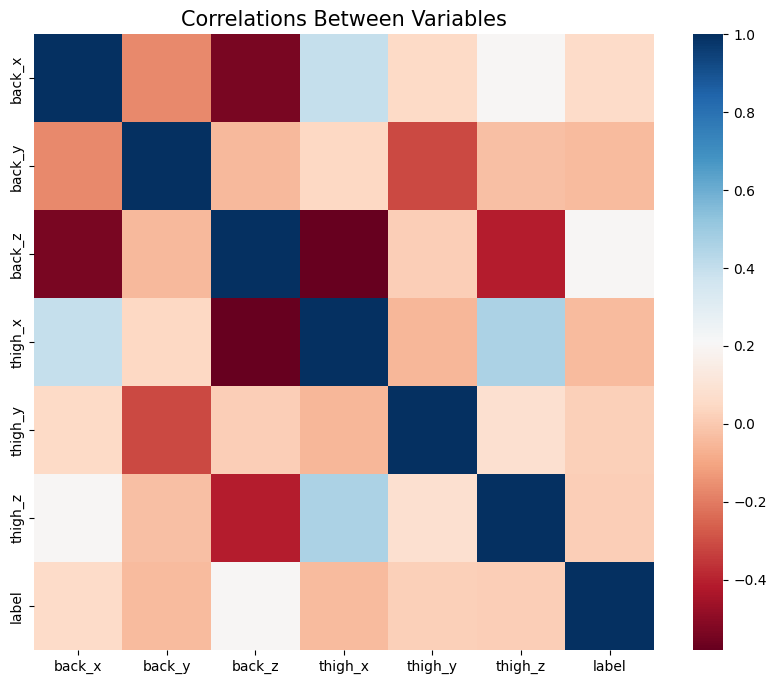

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

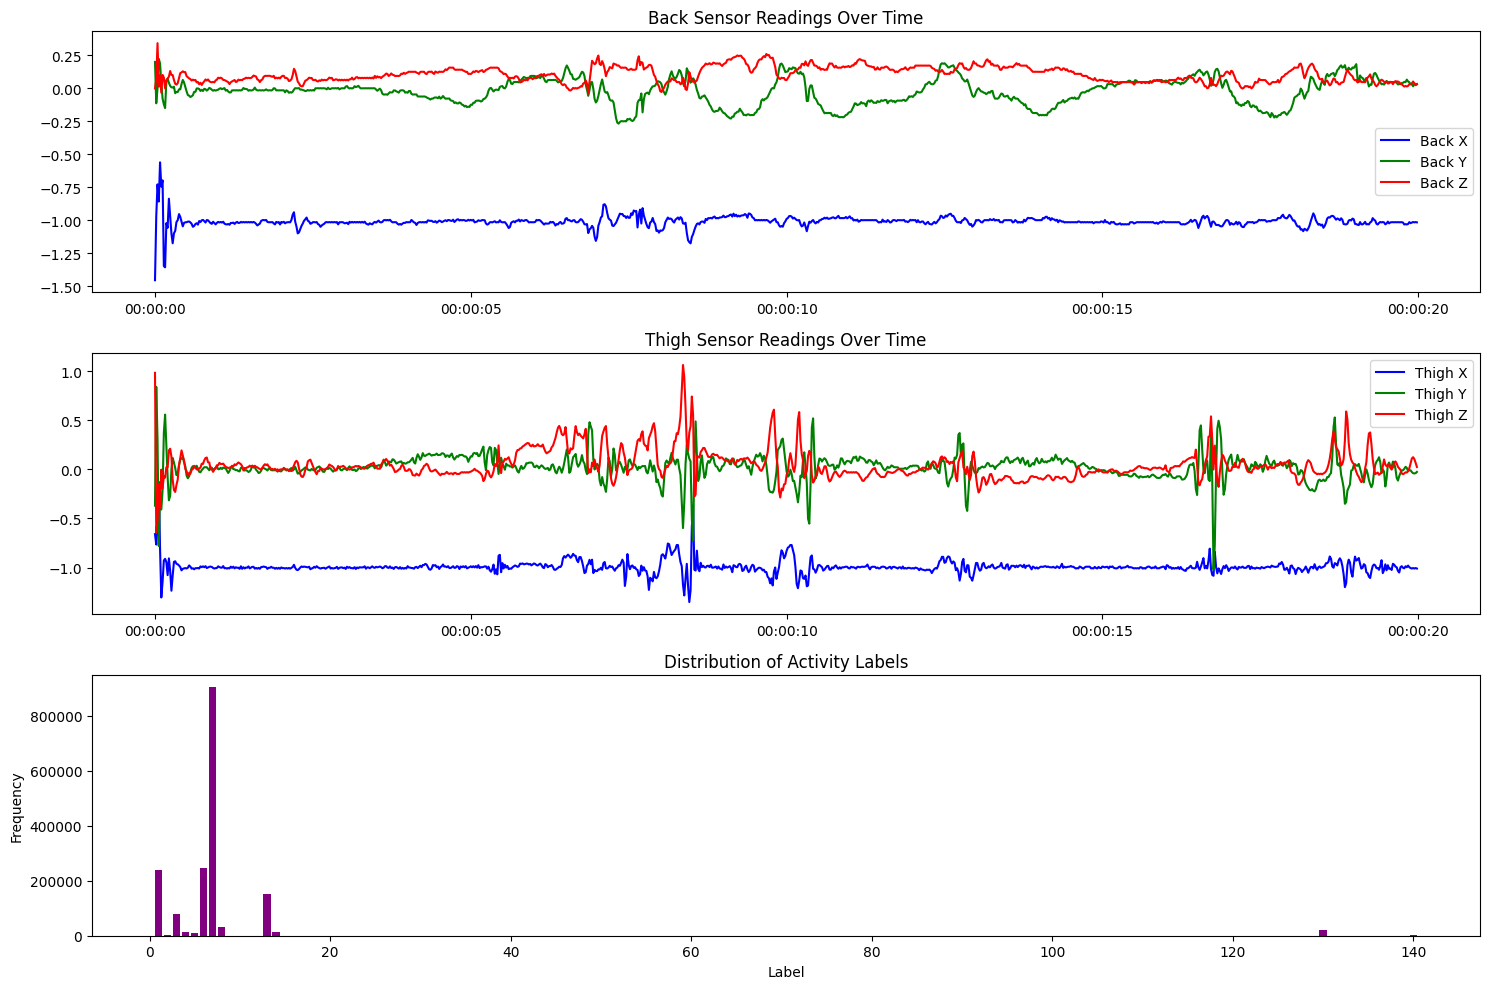

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['back_x'].iloc[:1000], label='Back X', color='b')
plt.plot(df['back_y'].iloc[:1000], label='Back Y', color='g')
plt.plot(df['back_z'].iloc[:1000], label='Back Z', color='r')
plt.title('Back Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['thigh_x'].iloc[:1000], label='Thigh X', color='b')
plt.plot(df['thigh_y'].iloc[:1000], label='Thigh Y', color='g')
plt.plot(df['thigh_z'].iloc[:1000], label='Thigh Z', color='r')
plt.title('Thigh Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, color='purple')
plt.title('Distribution of Activity Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
null_counts = df.isnull().sum()
print(null_counts)
df.describe()

back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64


,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06,1.716225e+06
mean,-9.136983e-01,5.232557e-03,-1.490021e-01,-5.126834e-01,6.135588e-02,5.457297e-01,8.036718e+00
std,2.165355e-01,1.429115e-01,3.586170e-01,5.332363e-01,2.403650e-01,5.939551e-01,1.449372e+01
min,-5.238408e+00,-3.016498e+00,-1.353473e+00,-6.863094e+00,-5.757406e+00,-5.651375e+00,1.000000e+00
25%,-1.002036e+00,-4.289968e-02,-3.162953e-01,-9.743656e-01,-5.570871e-02,-1.153043e-02,6.000000e+00
50%,-9.833325e-01,2.237414e-02,-8.577258e-02,-3.685415e-01,5.961482e-02,9.013961e-01,7.000000e+00
75%,-8.589005e-01,7.544386e-02,6.995789e-02,-6.059147e-02,1.654058e-01,9.945638e-01,7.000000e+00
max,9.521087e-01,2.589111e+00,4.909483e+00,4.092486e+00,4.809320e+00,5.391660e+00,1.400000e+02


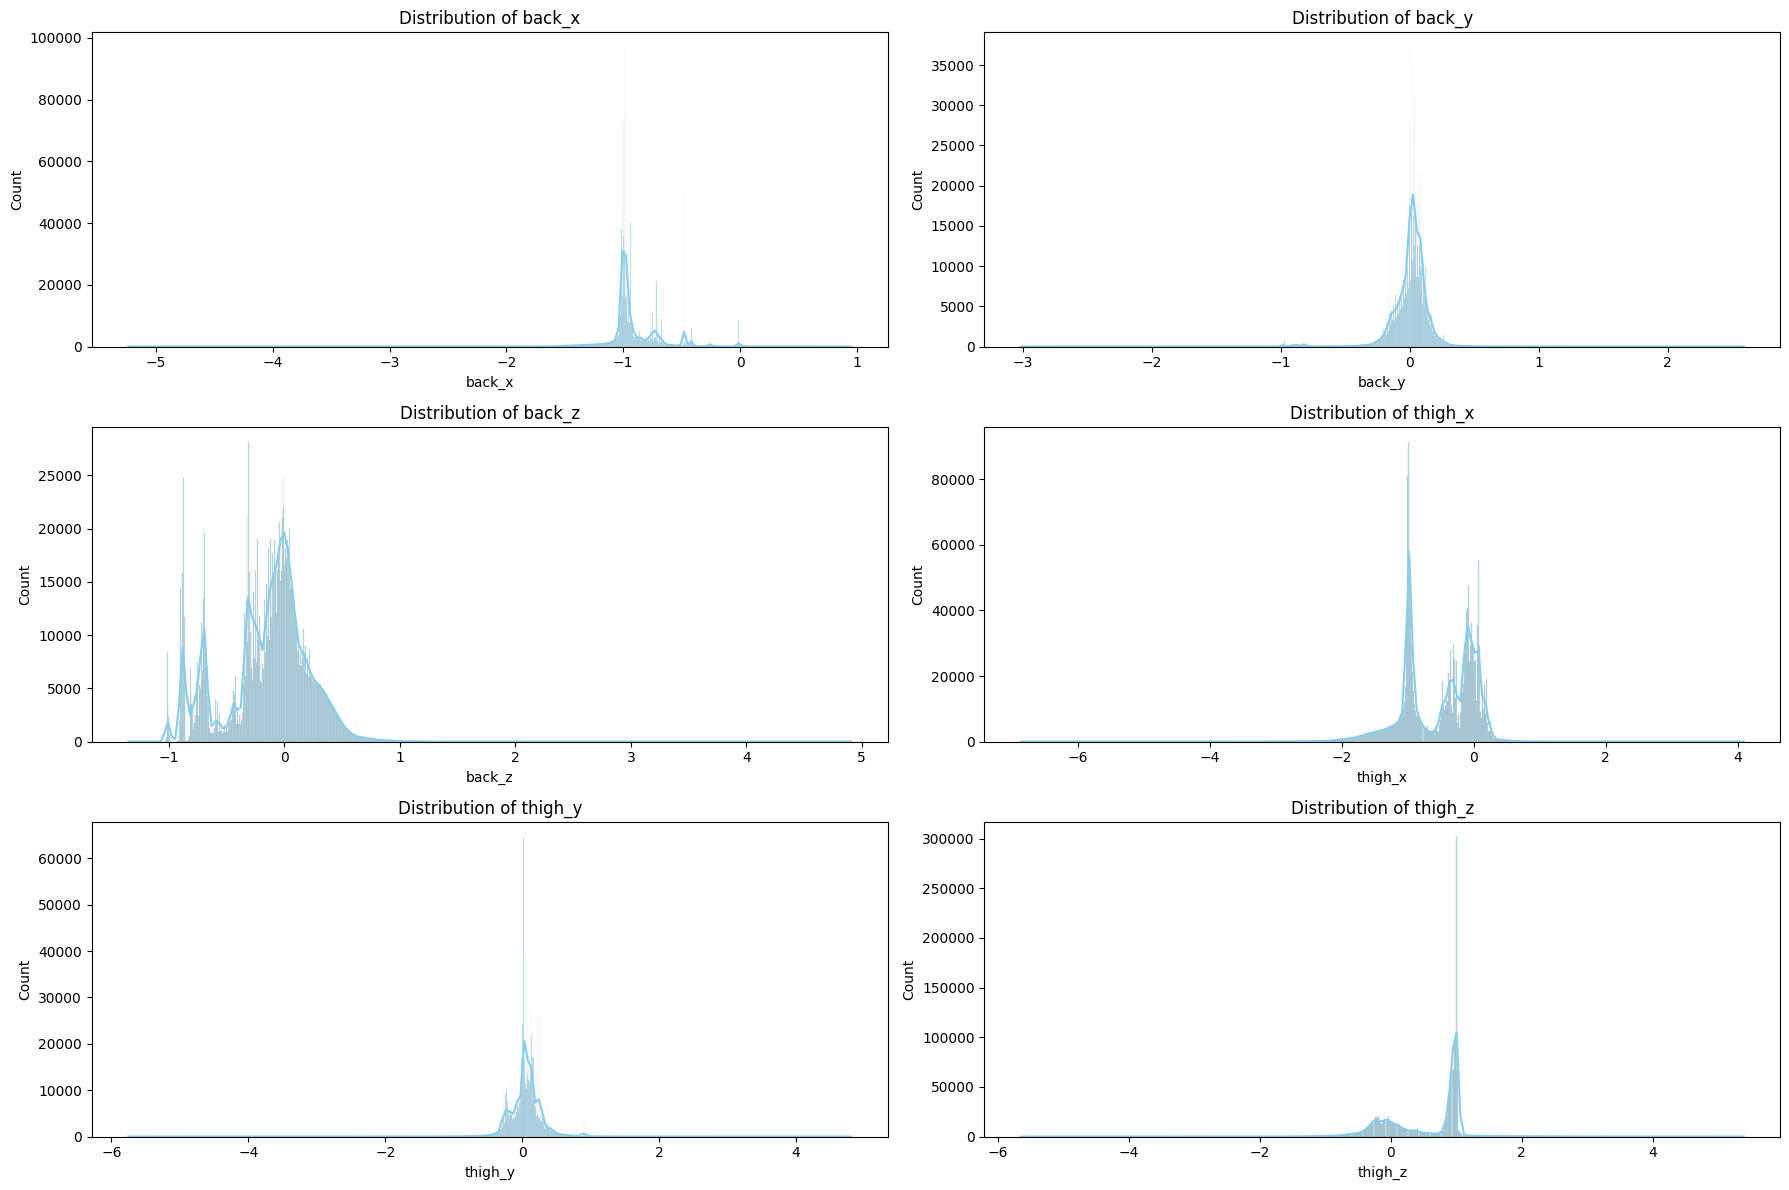

In [15]:
plt.figure(figsize=(18, 12))

sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
for i, column in enumerate(sensor_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

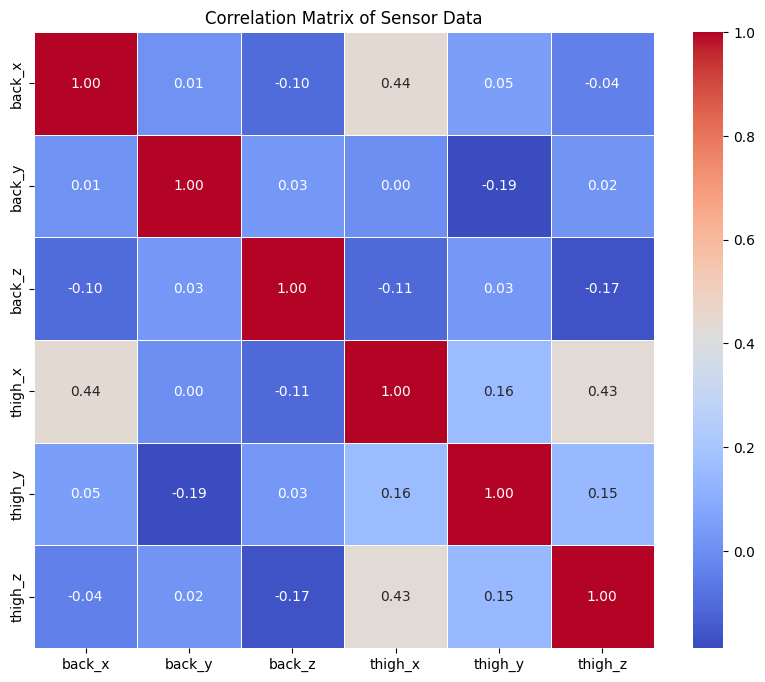

In [ ]:
# Correlation matrix
correlation_matrix = df[sensor_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sensor Data')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

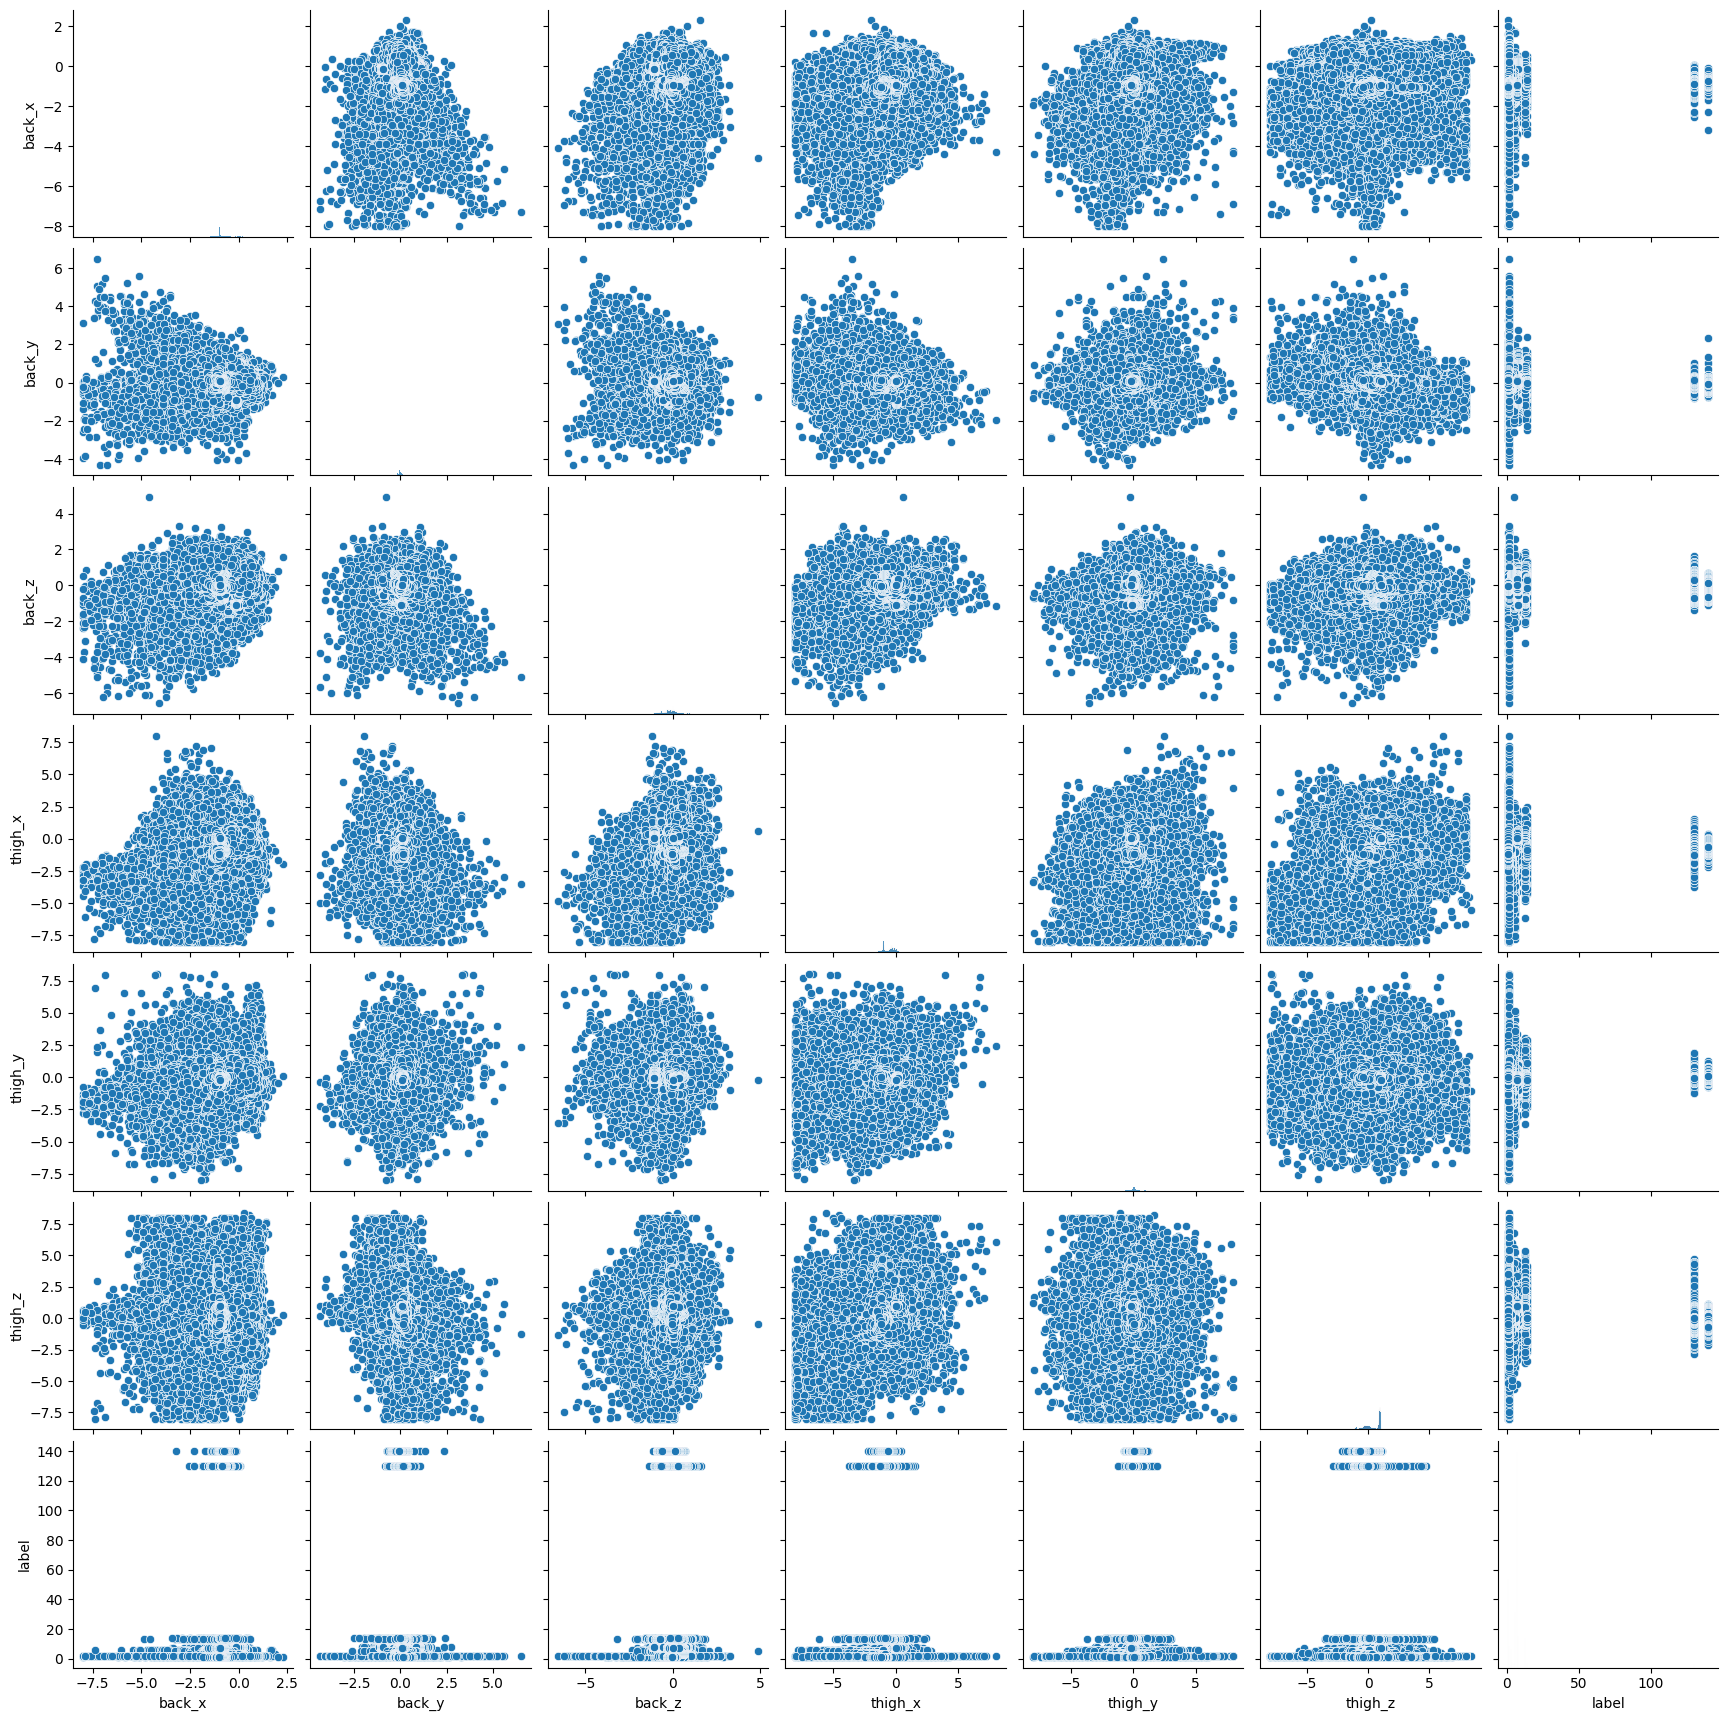

In [ ]:
sns.pairplot(df)